In [17]:
import pandas as pd
import joblib

clf = joblib.load("rf_area_classifier_full.pkl")

new_data = pd.read_csv("../2_Feature_Extraction/extract_features/tracking_features.csv")  
X_new = new_data.drop(columns=["tracking_id", "num_stops"])

new_data["predicted_label"] = clf.predict(X_new)
new_data.to_csv("new_tracking_predictions.csv", index=False)



<Axes: title={'center': 'Predicted Label Distribution'}, xlabel='predicted_label'>

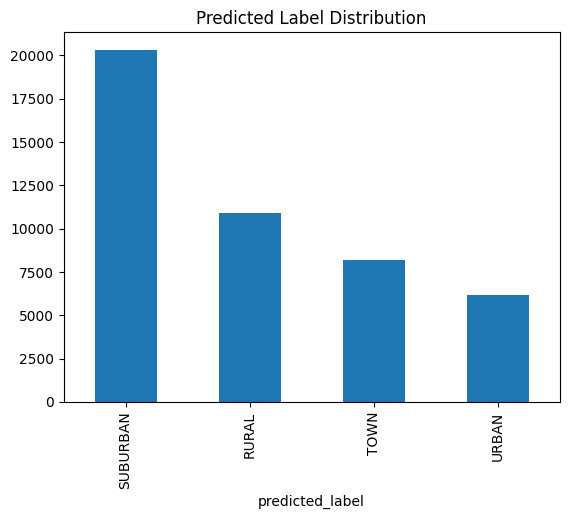

In [18]:
new_data["predicted_label"].value_counts().plot(kind="bar", title="Predicted Label Distribution")


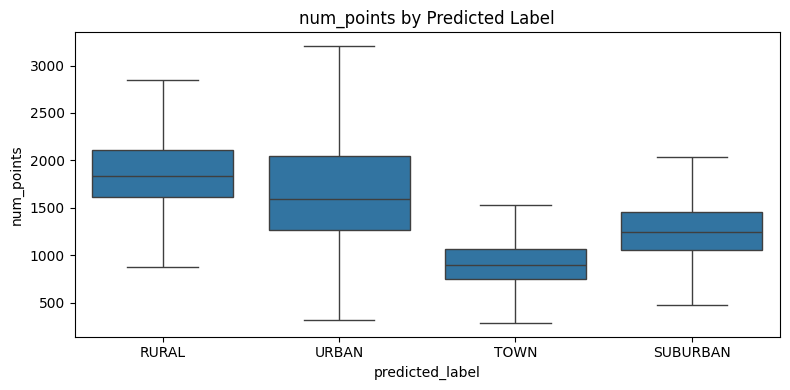

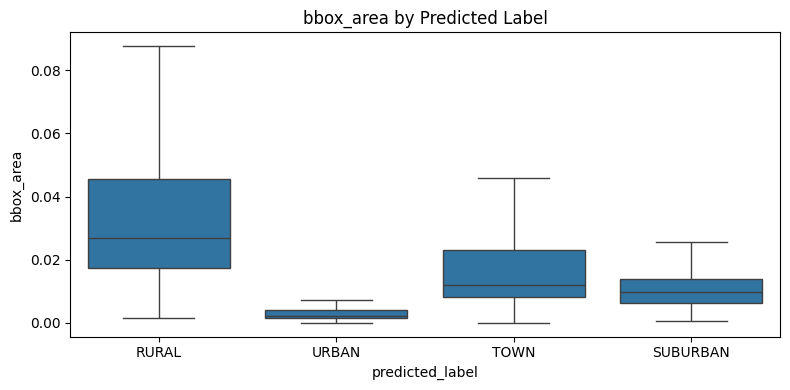

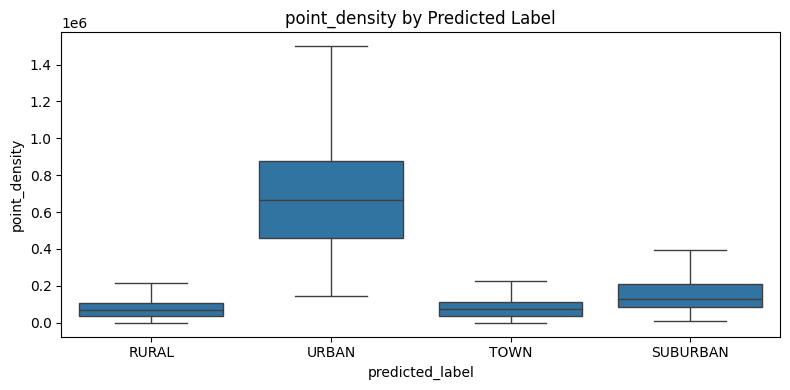

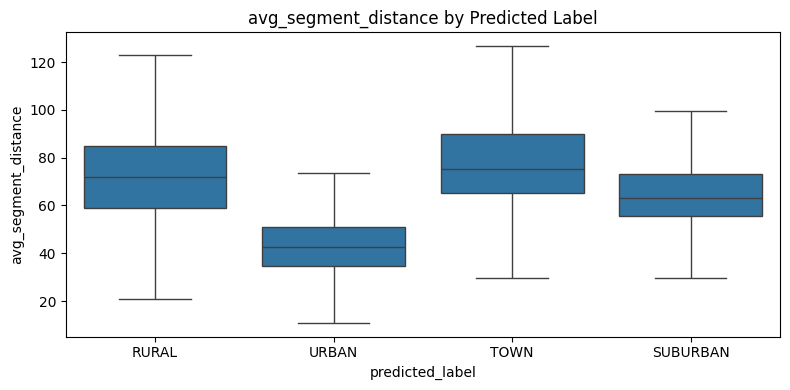

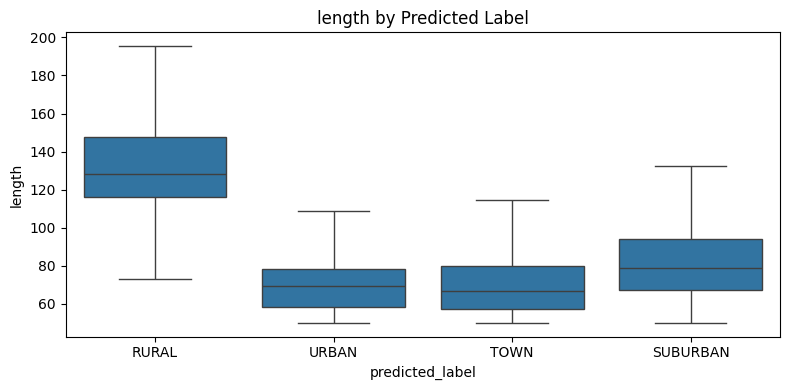

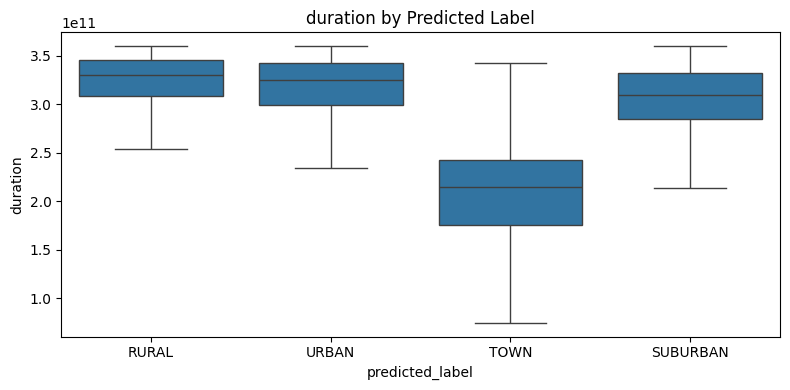

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

features_to_plot = ["num_points", "bbox_area", "point_density", "avg_segment_distance", "length", "duration"]

for feature in features_to_plot:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=new_data, x="predicted_label", y=feature, showfliers=False)
    plt.title(f"{feature} by Predicted Label")
    plt.tight_layout()
    plt.show()


In [20]:
df = pd.read_csv("new_tracking_predictions.csv")

for label in df["predicted_label"].unique():
    print(f"\n=== {label} ===")
    display(df[df["predicted_label"] == label].sample(3, random_state=42))



=== RURAL ===


tracking_id  num_points  bbox_area  point_density  \
11527        26270        1808   0.006116  295574.068817   
12898        28423        1437   0.016842   85316.493979   
12372        27699        1599   0.016260   98332.899287   

       avg_segment_distance  num_stops      duration      length  \
11527             64.212887       1808  321530000000  116.730874   
12898             84.995541       1437  303500000000  122.609790   
12372             78.689330       1599  312170000000  126.499384   

      predicted_label  
11527           RURAL  
12898           RURAL  
12372           RURAL


=== URBAN ===


tracking_id  num_points  bbox_area  point_density  \
26351        55639        1183   0.002264  522318.452562   
28469        60893        1246   0.001750  711499.229934   
44328        98447        1499   0.002648  565946.619327   

       avg_segment_distance  num_stops      duration     length  \
26351             54.390627       1183  331620000000  66.049501   
28469             39.855601       1246  310430000000  51.642360   
44328             38.465729       1499  357810000000  57.833351   

      predicted_label  
26351           URBAN  
28469           URBAN  
44328           URBAN


=== TOWN ===


tracking_id  num_points  bbox_area  point_density  \
15312        33039        1095   0.010630  103001.011924   
24354        50438         980   0.006979  140408.569724   
21586        45486         801   0.010858   73765.908320   

       avg_segment_distance  num_stops      duration     length  \
15312             80.634790       1095  192850000000  88.997523   
24354             71.038445        980  255960000000  70.060615   
21586             62.111017        801  153716068365  50.189856   

      predicted_label  
15312            TOWN  
24354            TOWN  
21586            TOWN


=== SUBURBAN ===


tracking_id  num_points  bbox_area  point_density  \
29139        62776        1656   0.005620  294598.350261   
21485        45327         921   0.008380  109894.168972   
31507        67674        1515   0.006985  216850.863002   

       avg_segment_distance  num_stops      duration     length  \
29139             55.261161       1656  335270000000  93.208797   
21485             62.133744        921  301780000000  58.068198   
31507             59.237633       1515  290800000000  91.273486   

      predicted_label  
29139        SUBURBAN  
21485        SUBURBAN  
31507        SUBURBAN

/tmp/ipykernel_18097/1753934054.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=2, random_state=42))["tracking_id"]


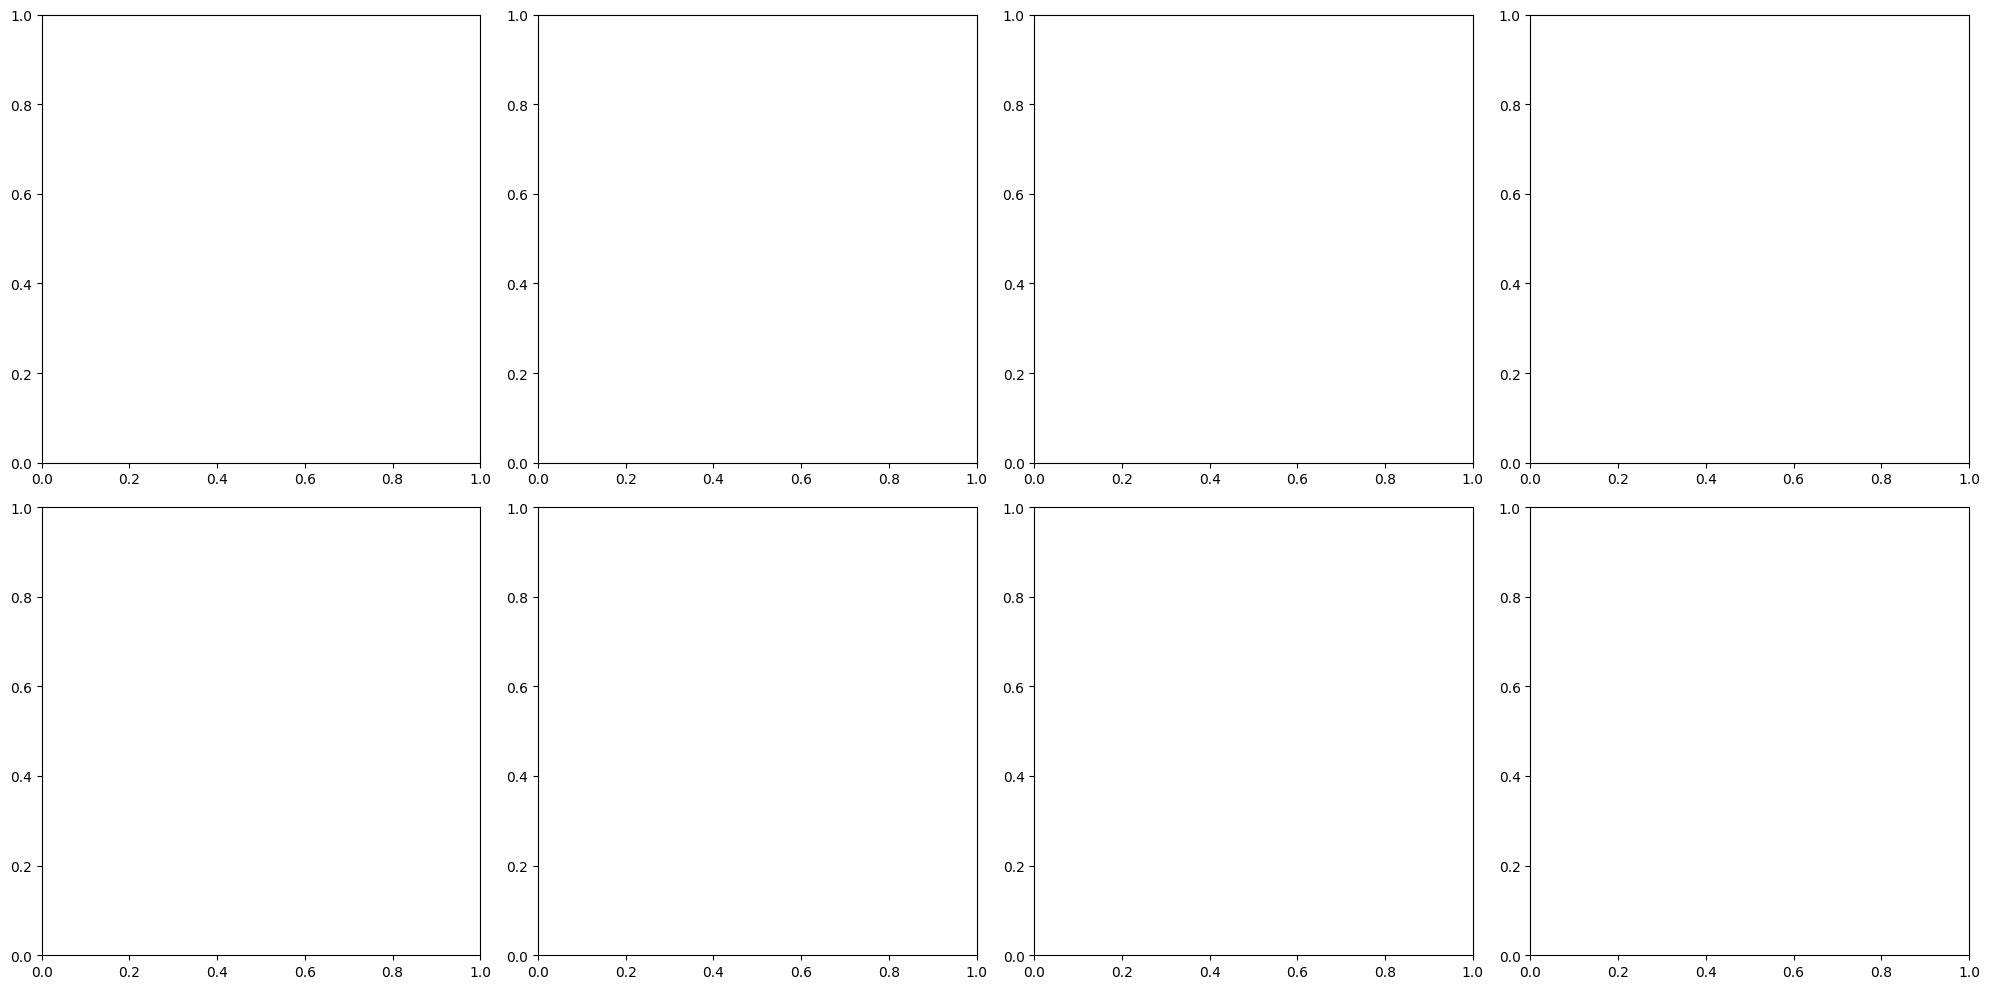

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd
from shapely.geometry import LineString

predicted_df = pd.read_csv("new_tracking_predictions.csv")
waypoints_df = pd.read_parquet("../2_Feature_Extraction/data/filtered_waypoints.parquet")

sampled_ids = (
    predicted_df.groupby("predicted_label")
    .apply(lambda x: x.sample(n=2, random_state=42))["tracking_id"]
    .explode()
    .tolist()
)

sampled_routes = waypoints_df[waypoints_df["id_tracking"].isin(sampled_ids)]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

color_map = {
    "RURAL": "red",
    "SUBURBAN": "orange",
    "TOWN": "blue",
    "URBAN": "green"
}

for i, tracking_id in enumerate(sampled_ids):
    ax = axes[i]
    route = sampled_routes[sampled_routes["id_tracking"] == tracking_id].sort_values("sequence")
    coords = list(zip(route["longitude"], route["latitude"]))
    label = predicted_df[predicted_df["tracking_id"] == tracking_id]["predicted_label"].values[0]

    if len(coords) < 2:
        continue

    line = LineString(coords)
    gdf = gpd.GeoDataFrame(index=[0], geometry=[line], crs="EPSG:4326").to_crs(epsg=3857)

    gdf.plot(ax=ax, color=color_map.get(label, "gray"), linewidth=2)
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

    ax.set_title(f"{label} - ID {tracking_id}", fontsize=9)
    ax.set_axis_off()

for j in range(len(sampled_ids), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
# plt.savefig("Figures/predicted_tracking_routes_mapgrid.png", dpi=300)
plt.show()


/tmp/ipykernel_18097/1810225943.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=trackings_per_group, random_state=42))["tracking_id"]


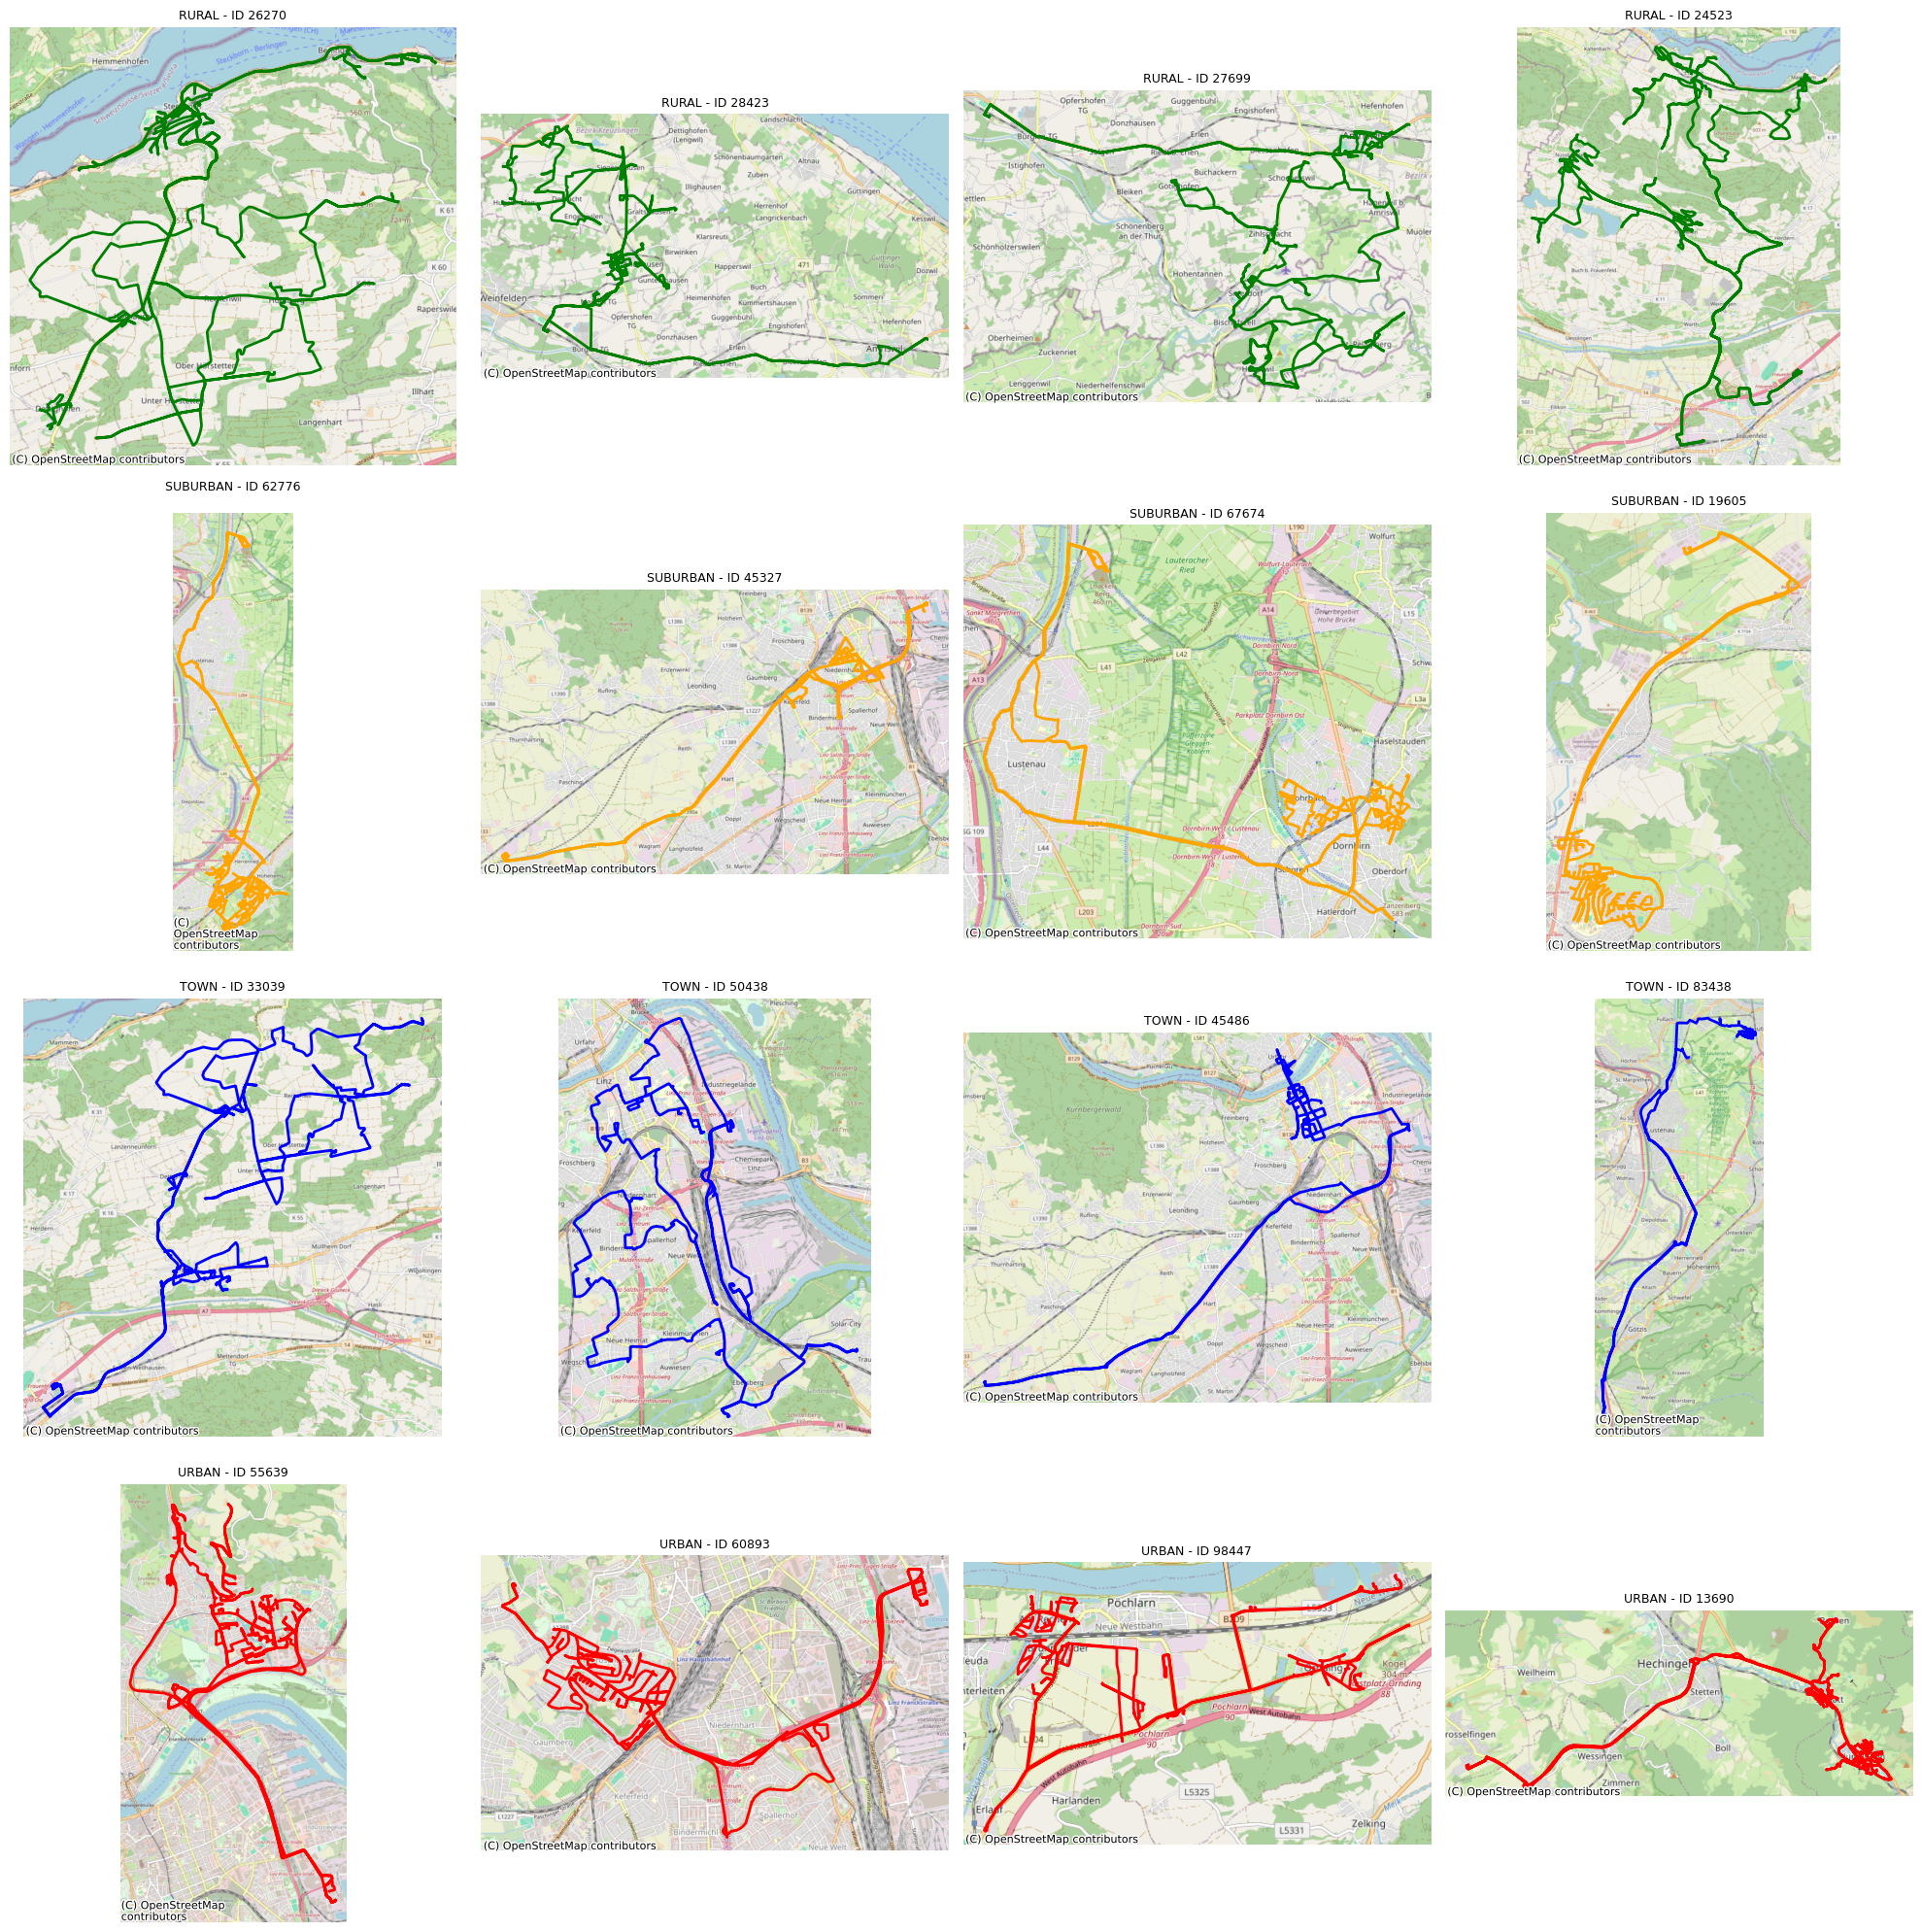

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd
from shapely.geometry import LineString
import pyarrow.parquet as pq

# Load predictions (small file)
predicted_df = pd.read_csv("new_tracking_predictions.csv")

trackings_per_group = 4

# Sample 2 IDs per predicted label
sampled_ids = (
    predicted_df.groupby("predicted_label")
    .apply(lambda x: x.sample(n=trackings_per_group, random_state=42))["tracking_id"]
    .explode()
    .tolist()
)

# Efficiently load only the required trackings from large Parquet file
table = pq.read_table(
    "../Data_Preperation/filtered_data_full_1.parquet",
    filters=[("id_tracking", "in", sampled_ids)]
)
sampled_routes = table.to_pandas()

# Plotting
fig, axes = plt.subplots(trackings_per_group, 4, figsize=(20, 20))
axes = axes.flatten()

color_map = {
    "URBAN": "red",
    "SUBURBAN": "orange",
    "TOWN": "blue",
    "RURAL": "green",
}

for i, tracking_id in enumerate(sampled_ids):
    ax = axes[i]
    route = sampled_routes[sampled_routes["id_tracking"] == tracking_id].sort_values("sequence")
    coords = list(zip(route["longitude"], route["latitude"]))
    label = predicted_df[predicted_df["tracking_id"] == tracking_id]["predicted_label"].values[0]

    if len(coords) < 2:
        continue

    line = LineString(coords)
    gdf = gpd.GeoDataFrame(index=[0], geometry=[line], crs="EPSG:4326").to_crs(epsg=3857)

    gdf.plot(ax=ax, color=color_map.get(label, "gray"), linewidth=2)
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

    ax.set_title(f"{label} - ID {tracking_id}", fontsize=9)
    ax.set_axis_off()

# Hide any unused subplots
for j in range(len(sampled_ids), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

